<a href="https://colab.research.google.com/github/onepixelm/Hazi-02/blob/master/gyakandweather02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


#lp = np.linspace(1,1000,1000)

In [2]:

print(lp.shape,type(lp))

(1000,) <class 'numpy.ndarray'>


In [3]:
from google.colab import files

uploaded = files.upload()
file  = open("BP_d.txt", 'r')  
head = file.readlines()[1:] 
file.close()

Saving BP_d.txt to BP_d.txt


In [4]:
head2 = [ float(s.split(';')[1]) for s in head ]
print(len(head2))

min_temp = head2[0]
max_temp = head2[0]
for t in head2:
  if t < min_temp:
    min_temp = t
  if t > max_temp:
    max_temp = t
print("Min temp: {} Max temp: {}".format(min_temp,max_temp))
x = (np.asarray([head2[-40000:]]) - min_temp)/(max_temp - min_temp)
 #x = x.T

40177
Min temp: -20.6 Max temp: 33.1


In [5]:
print(x.shape,type(x))
x.shape = (40000,) 
 #x.reshape(1000)
print(x.shape,type(x))

(1, 40000) <class 'numpy.ndarray'>
(40000,) <class 'numpy.ndarray'>


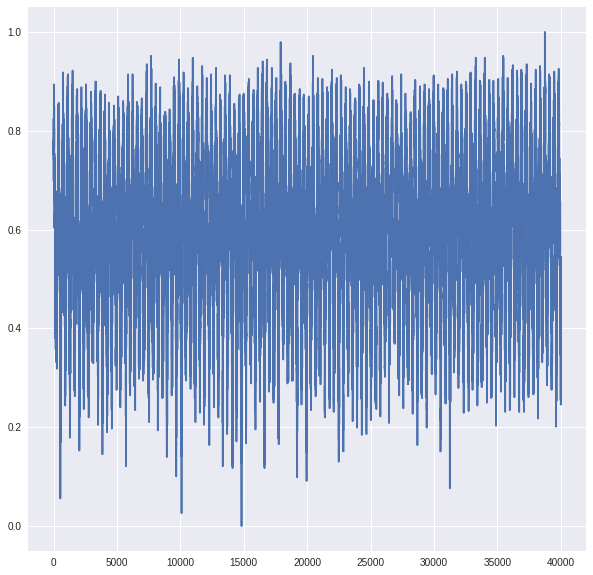

In [6]:
plt.figure(figsize=(10,10))
plt.plot(x)

In [7]:
window_size=20

valid_split=0.3
test_split =0.2

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import preprocessing
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Conv1D

def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_output=1, nb_filter=4):
  model = Sequential()
  # Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu',...)
  model.add(Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', 
                           input_shape=(window_size, nb_input_series, )))
  model.add(MaxPooling1D()) # filter:2, stride:2
  model.add(Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu'))
  model.add(MaxPooling1D()) # filter:2, stride:2
  model.add(Flatten())  
  model.add(Dense(1,activation='linear'))
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  
  return model

#model=make_1d_convnet(window_size=window_size, filter_length=5)

Using TensorFlow backend.


In [0]:
def make_timeseries_innstance(timeseries, window_size):
  timeseries = np.asarray(timeseries)
  assert 0 < window_size < timeseries.shape[0], "Out of range"
  
  X = np.atleast_3d(np.array([timeseries[start:start+window_size] for start in range(0,timeseries.shape[0]-window_size)]))
  
  assert len(X.shape) == 3, "Dimension error"
  Y = timeseries[window_size:]
  
  return X, Y
  

In [0]:
def eval_timeseries(timeseries, window_length):
  filter_length = 5
  nb_filter = 4
  timeseries = np.atleast_2d(timeseries)
  if timeseries.shape[0]==1:
    timeseries = timeseries.T
  nb_samples, nb_series = timeseries.shape
  
  model=make_1d_convnet(window_size=window_size, 
                        filter_length=filter_length, 
                        nb_input_series=nb_series,
                        nb_filter=nb_filter)
  
  print(model.summary())
  X, Y = make_timeseries_innstance(timeseries, window_size)
  
  test_size = int(nb_samples*(1-test_split))
  valid_size = int(nb_samples*(1-valid_split-test_split))
  
  X_train, Y_train = X[:valid_size], Y[:valid_size]
  X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
  X_test, Y_test   = X[test_size:], Y[test_size:]
  
  ##$$$$$ NE FELEJTSETEK EL A STANDARADIZALAST $$$$$$
  ##$$$$$$ NE FELEJTESTEK EL EARLY STOPPINGOT ES MCP-t $$$$
  
  model.fit(X_train, Y_train, epochs=50, validation_data=[X_valid,Y_valid], verbose=2)
  
  ##$$$$$ NE FELETSETEK EL AZ MCP-t VISSZATOLTENI $$$$
  
  preds = model.predict(X_test)
  
  plt.figure(figsize=(10,20))
  plt.plot(preds, color='r')
  plt.plot(Y_test, color='b')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(20, 1), filters=4, kernel_size=5)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=4, kernel_size=5)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 4)             24        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
None
Train o

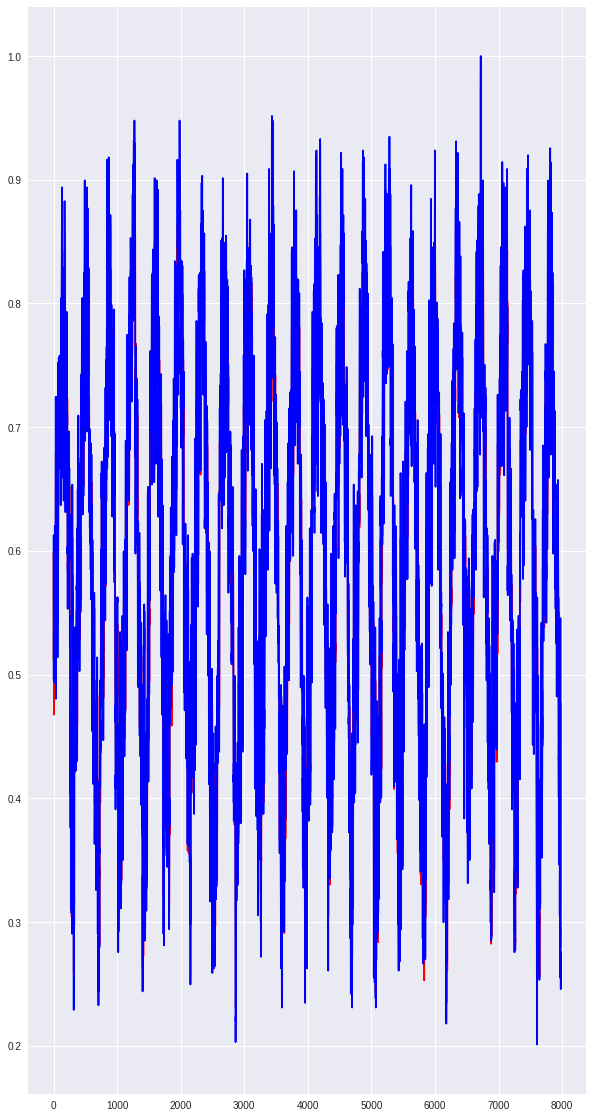

In [10]:
eval_timeseries(x, window_size)

In [11]:
 plt.figure(figsize=(10,20))
 plt.plot(preds, color='r')
 plt.plot(Y_test, color='b')

NameError: ignored